In [39]:
from torch.utils.data import Dataset, DataLoader
from torchvision.datasets import ImageFolder
from torchvision import transforms

from PIL import Image

import cv2

import torch
import torch.nn as nn
import torch.nn.functional as F
import pandas as pd
import re
import os
import numpy as np
import re

from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix


import matplotlib.pyplot as plt

import math

In [2]:

if torch.cuda.is_available():
  device = torch.device("cuda:0")
  print("GPU")
else:
  device = torch.device("cpu")
  print("CPU")

GPU


In [3]:
"""from google.colab import drive
drive.mount('/content/drive')
!unzip -uq "/content/drive/MyDrive/DDD Project/Driver Drowsiness Dataset (DDD)/archive.zip"
"""

'from google.colab import drive\ndrive.mount(\'/content/drive\')\n!unzip -uq "/content/drive/MyDrive/DDD Project/Driver Drowsiness Dataset (DDD)/archive.zip"\n'

In [4]:
# Add image paths, labels, file names and person IDs into lists
image_path, label, file_name, person_ID = [], [], [], []

pattern = re.compile(r'^[a-zA-Z][a-zA-Z]?') #identification criteria of participant

#data_dir = "/content/drive/MyDrive/newdata/Driver Drowsiness Dataset (DDD)/"

path = os.getcwd()
data_dir = path + str('/Driver Drowsiness Dataset (DDD)/')

for class_name in os.listdir(data_dir):  #goes through all folders in DDD folder
  for path in os.listdir(data_dir+class_name):  #goes through all files in both folders and updates file path and labels
    if class_name == 'Drowsy':
      label.append(0)
    else:
      label.append(1)
    image_path.append(os.path.join(data_dir, class_name, path))
    file_name.append(path)

    person_ID.append(pattern.findall(path)[0])  #identification of participant


#dataframe with path, label, file name, person_ID of all Persons
df = pd.DataFrame()
df['images'] = image_path
df['label'] = label
df['name'] = file_name
df['person'] = person_ID

print('df')
print(df.shape)


#add Person E and G only to the Test Dataset
dfTest = pd.concat([df[df['person']=='m'], df[df['person']=='M'], df[df['person']=='u'], df[df['person']=='U'], df[df['person']=='za'], df[df['person']=='ZA']])
print('dfTest')
print(dfTest.shape)


#remove Person E and G from the dataset with all Persons
dfWithout = df
dfWithout = dfWithout.drop(index=(df[df['person']=='m'].index))
dfWithout = dfWithout.drop(index=(df[df['person']=='M'].index))
dfWithout = dfWithout.drop(index=(df[df['person']=='u'].index))
dfWithout = dfWithout.drop(index=(df[df['person']=='U'].index))

dfWithout = dfWithout.drop(index=(df[df['person']=='za'].index))
dfWithout = dfWithout.drop(index=(df[df['person']=='ZA'].index))

print('dfWithout')
print(dfWithout.shape)


#converting imagepath and label of takeout persons G, E into an nparray
imagePathTakeout = dfTest['images']
labelTakeout = dfTest['label']

imagePathTO = np.array(imagePathTakeout).reshape([-1,1])
labelTO = np.array(labelTakeout).reshape([-1,1])
testTO = np.hstack((imagePathTO, labelTO))

print('testTO')
print(testTO.shape)


#converting imagepath and label of all other persons into an nparray
imagePathWithout = dfWithout['images']
labelWithout = dfWithout['label']

image_path = np.array(imagePathWithout).reshape([-1,1])
label = np.array(labelWithout).reshape([-1,1])
comp_data = np.hstack((image_path, label))

df
(41793, 4)
dfTest
(3855, 4)
dfWithout
(37938, 4)
testTO
(3855, 2)


In [5]:


print(testTO)
     


[['/rwthfs/rz/cluster/home/ko617013/techlabs/Driver Drowsiness Dataset (DDD)/Non Drowsy/m0420.png'
  1]
 ['/rwthfs/rz/cluster/home/ko617013/techlabs/Driver Drowsiness Dataset (DDD)/Non Drowsy/m0364.png'
  1]
 ['/rwthfs/rz/cluster/home/ko617013/techlabs/Driver Drowsiness Dataset (DDD)/Non Drowsy/m0361.png'
  1]
 ...
 ['/rwthfs/rz/cluster/home/ko617013/techlabs/Driver Drowsiness Dataset (DDD)/Drowsy/ZA0108.png'
  0]
 ['/rwthfs/rz/cluster/home/ko617013/techlabs/Driver Drowsiness Dataset (DDD)/Drowsy/ZA0286.png'
  0]
 ['/rwthfs/rz/cluster/home/ko617013/techlabs/Driver Drowsiness Dataset (DDD)/Drowsy/ZA0751.png'
  0]]


In [56]:


result = df.groupby("person").size()
print(result)


person
A     1411
B      315
C      335
D      179
E      962
F      415
G      499
H      508
I     1095
J      474
K      630
L      732
M      777
N     1156
O     1097
P      963
Q      562
R      204
S      487
T      933
U      420
V      653
W     1162
X     1749
Y     1112
ZA     621
ZB    1551
ZC    1346
a     1252
b      409
c      400
d     1005
e     1000
g      109
h      571
i     1045
j      717
k      538
l      381
m      473
n      957
o      671
p      190
q      521
r      522
s      457
u      510
v     1002
w      493
x     1143
y     1500
za    1054
zb    1237
zc    1288
dtype: int64


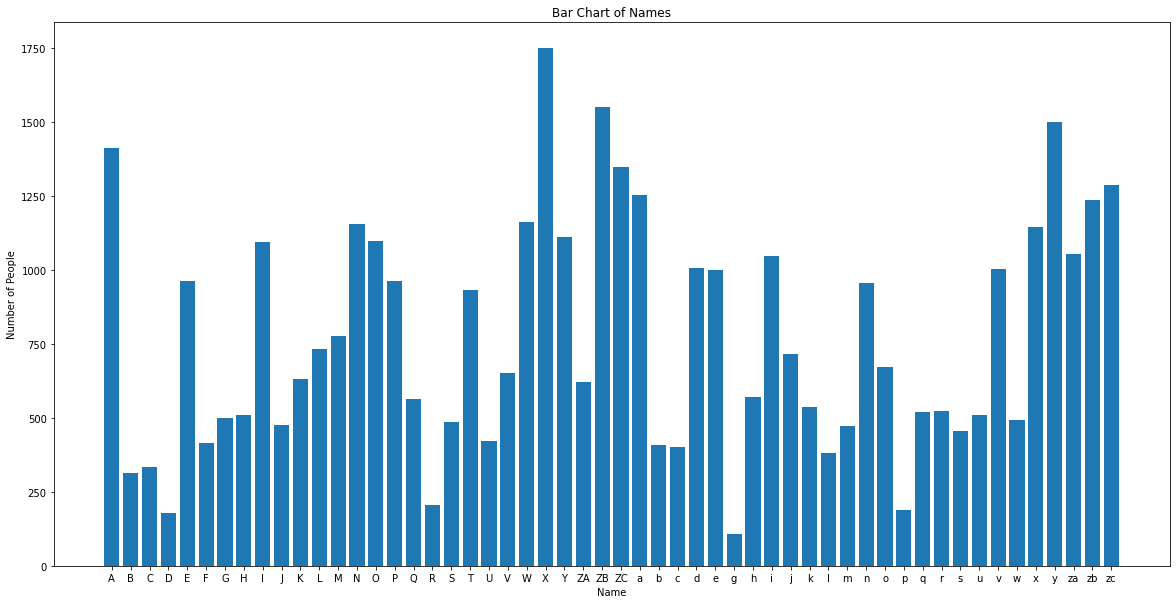

In [55]:

plt.figure(figsize=(20,10))
plt.bar(result.index, result.values, )
plt.xlabel('Name')
plt.ylabel('Number of People')
plt.title('Bar Chart of Names')
plt.show()

In [7]:
from sklearn.model_selection import train_test_split

#nparray with all other persons (except of E, G) gets split into train and test dataset
trainW, testW = train_test_split(comp_data, test_size=0.2, random_state=1234)
print('trainW')
print(trainW.shape)

print('testW')
print(testW.shape)


#train dataset
train = trainW


#test dataset is a combination of the takeout of person E, G and the part that was split to test via train_test_split
test = np.concatenate((testTO, testW))


print('test')
print(test.shape)
print(train)

trainW
(30350, 2)
testW
(7588, 2)
test
(11443, 2)
[['/rwthfs/rz/cluster/home/ko617013/techlabs/Driver Drowsiness Dataset (DDD)/Non Drowsy/zb1246.png'
  1]
 ['/rwthfs/rz/cluster/home/ko617013/techlabs/Driver Drowsiness Dataset (DDD)/Non Drowsy/zc1522.png'
  1]
 ['/rwthfs/rz/cluster/home/ko617013/techlabs/Driver Drowsiness Dataset (DDD)/Drowsy/X0177.png'
  0]
 ...
 ['/rwthfs/rz/cluster/home/ko617013/techlabs/Driver Drowsiness Dataset (DDD)/Drowsy/B0173.png'
  0]
 ['/rwthfs/rz/cluster/home/ko617013/techlabs/Driver Drowsiness Dataset (DDD)/Drowsy/Y0727.png'
  0]
 ['/rwthfs/rz/cluster/home/ko617013/techlabs/Driver Drowsiness Dataset (DDD)/Drowsy/J0332.png'
  0]]


In [8]:
class DDDdataset(Dataset):
  def __init__(self, image_paths, image_labels, transform):
    super().__init__()
    self.paths = image_paths
    self.labels = image_labels
    self.len = len(self.paths)
    self.transform = transform
  
  def __len__(self): return self.len
  
  def __getitem__(self, index):
    path = self.paths[index]
    label = self.labels[index]
    target_tensor=torch.from_numpy(np.array(label,dtype=np.int16))
    #image = Image.open(path).convert('RGB')
    image = cv2.imread(path,cv2.IMREAD_UNCHANGED)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = self.transform(image)
    return (image, target_tensor, path)

# Standardisation

In [9]:
"""#transformation for the calculation of mean and std for the train dataset
transformationCalc = transforms.Compose([
    #ToTensor() includes an automatic scaling from the interval (0,255) to (0.0,1.0)
    transforms.ToTensor()
])

#train dataset and loader for the calculation of mean and std for the train dataset
trainDatasetCalc = DDDdataset(train[:,0], train[:,-1], transformationCalc)

loaderCalc = DataLoader(trainDatasetCalc, batch_size=128, shuffle=True)"""

'#transformation for the calculation of mean and std for the train dataset\ntransformationCalc = transforms.Compose([\n    #ToTensor() includes an automatic scaling from the interval (0,255) to (0.0,1.0)\n    transforms.ToTensor()\n])\n\n#train dataset and loader for the calculation of mean and std for the train dataset\ntrainDatasetCalc = DDDdataset(train[:,0], train[:,-1], transformationCalc)\n\nloaderCalc = DataLoader(trainDatasetCalc, batch_size=128, shuffle=True)'

In [10]:
"""sum = []
sum = np.zeros((3))
no_of_pixels = len(trainDatasetCalc)*227*227
for batch in loaderCalc: 
  

  for i in range(3) : #no of channels
    
  
    sum[i] += batch[0][:,i,:,:].sum()
  """



'sum = []\nsum = np.zeros((3))\nno_of_pixels = len(trainDatasetCalc)*227*227\nfor batch in loaderCalc: \n  \n\n  for i in range(3) : #no of channels\n    \n  \n    sum[i] += batch[0][:,i,:,:].sum()\n  '

In [11]:
"""mean = sum / no_of_pixels
print(mean)"""

'mean = sum / no_of_pixels\nprint(mean)'

In [12]:
"""sum_sq = []
sum_sq = np.zeros((3))
for batch in loaderCalc:
  for i in range(3) : #no of channels
      
      sum_sq[i] += ((batch[0][:,i,:,:]-mean[i]).pow(2)).sum()"""
      
   

'sum_sq = []\nsum_sq = np.zeros((3))\nfor batch in loaderCalc:\n  for i in range(3) : #no of channels\n      \n      sum_sq[i] += ((batch[0][:,i,:,:]-mean[i]).pow(2)).sum()'

In [13]:
"""std = np.sqrt(sum_sq/no_of_pixels)
print(std)"""

'std = np.sqrt(sum_sq/no_of_pixels)\nprint(std)'

In [14]:
mean = [0.5055243 , 0.3837401 , 0.33682286]
std = [0.24825575, 0.22582591 ,0.21188137]

In [19]:
#transformation for model training and testing
transformation = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=mean, std=std)    ###changed format of mean and std 
])


#datasets and dataloaders for model training and testing
trainDataset = DDDdataset(train[:,0], train[:,-1], transformation)
testDataset = DDDdataset(test[:,0], test[:,-1], transformation)


trainDataLoader = DataLoader(trainDataset, batch_size=64, shuffle=True, num_workers = 8)  ## added num_workers parameter here
testDataLoader = DataLoader(testDataset, batch_size=64, shuffle=True, num_workers = 8)  ## added num_workers parameter here
     

In [20]:

"""
--------------------------------
number of parameters CNN below

(II) f*f*ch_in*ch_out + ch_out_bias = params_conv_layer

(III) numberOfInputImageElements*outputFeaturesCurrentFCLayer = params_fully_connected

conv1: 4*4*3*10 + 10 = 490 -> 4*4 filter, 3 input image channels, 10 number of filters, +10 bias parameters of each filter
conv2: 5*5*10*20 + 20 = 5020
conv3: 6*6*20*32 + 32 = 23072
conv4: 3*3*32*40 + 40 = 11560

after conv4 layer: output "image": 3*3*40 = 360

fc1: 360*50 + 50 = 18050 -> fc1 has 50 output features
fc2: 50*20 + 20 = 1020
fc3: 20*2 + 2 = 42

complete CNN: 59254 parameters
"""

'\n--------------------------------\nnumber of parameters CNN below\n\n(II) f*f*ch_in*ch_out + ch_out_bias = params_conv_layer\n\n(III) numberOfInputImageElements*outputFeaturesCurrentFCLayer = params_fully_connected\n\nconv1: 4*4*3*10 + 10 = 490 -> 4*4 filter, 3 input image channels, 10 number of filters, +10 bias parameters of each filter\nconv2: 5*5*10*20 + 20 = 5020\nconv3: 6*6*20*32 + 32 = 23072\nconv4: 3*3*32*40 + 40 = 11560\n\nafter conv4 layer: output "image": 3*3*40 = 360\n\nfc1: 360*50 + 50 = 18050 -> fc1 has 50 output features\nfc2: 50*20 + 20 = 1020\nfc3: 20*2 + 2 = 42\n\ncomplete CNN: 59254 parameters\n'

In [21]:


#LAYERS OF THE MODEL

class CNN(nn.Module):
  def __init__(self):
    super().__init__()

    self.conv1 = nn.Conv2d(in_channels=3, out_channels=10, kernel_size=(4,4), stride=1, padding=1)
    self.bn1 = nn.BatchNorm2d(10)
    self.conv2 = nn.Conv2d(in_channels=10, out_channels=15, kernel_size=(5,5), stride=2, padding=1)
    self.bn2 = nn.BatchNorm2d(15)
    self.conv3 = nn.Conv2d(in_channels=15, out_channels=20, kernel_size=(6,6), stride=2, padding=1)
    self.bn3 = nn.BatchNorm2d(20)
    self.conv4 = nn.Conv2d(in_channels=20, out_channels=25, kernel_size=(3,3), stride=1, padding=1)
    self.bn4 = nn.BatchNorm2d(25)

    self.fc1 = nn.Linear(in_features=25*3*3, out_features=45)
    self.bn5 = nn.BatchNorm1d(45)
    self.fc2 = nn.Linear(in_features=45, out_features=20)
    self.bn6 = nn.BatchNorm1d(20)
    self.fc3 = nn.Linear(in_features=20, out_features=2)

  def forward(self, X):

    X = F.relu(self.bn1(self.conv1(X)))
    X = F.max_pool2d(X, 2)
    X = F.relu(self.bn2(self.conv2(X)))
    X = F.max_pool2d(X, 2)
    X = F.relu(self.bn3(self.conv3(X)))
    X = F.max_pool2d(X, 3, stride=2)
    X = F.relu(self.bn4(self.conv4(X)))
    X = F.max_pool2d(X, 2)

    X = X.view(X.shape[0], -1)
    X = F.relu(self.bn5(self.fc1(X)))
    X = F.relu(self.bn6(self.fc2(X)))
    X = self.fc3(X)

    return X

     



In [60]:
#MODEL TRAINING AND TESTING

import time

#basic settings
model = CNN().to(device)
number_epochs = 4
loss_func = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
losses = []
accuracies = []
test_losses = []
test_accuracies = []

train_preds = []
test_preds_list = []

train_class = []
test_class = []

#for the analysis of the wrong classifications
pathsOfWrongClassifications = []
rowsOfWrongClassifications = []
correctLabel = []
epochOfWrongClassification = []


start = time.time()
#model training and testing process
for epoch in range(number_epochs):
  train_preds = []
  test_preds_list = []

  train_class = []
  test_class = []

  epoch_loss = 0
  epoch_accuracy = 0
  
  #-------model training-------
  for (X, y, path) in trainDataLoader:
    X = X.to(device) #torch.as_tensor(X)
    y = y.to(device) #torch.as_tensor(y)
    train_class.extend(y.cpu().tolist())   #list of true labels
    
    predictions = model(X)
    
    
    pred_class = predictions.argmax(dim=1)
    train_preds.extend(pred_class.cpu().tolist())    #list of predicted labels
    
    
    
    loss = loss_func(predictions, y.long())

    #adaption of the neural network
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    #
    accuracy = ((predictions.argmax(dim=1) == y).float().mean())
    
    epoch_accuracy += accuracy.cpu().detach().numpy()
    epoch_loss += loss.cpu().detach().numpy()
  
  #total epoch_accuracy and epoch_loss calculation
  epoch_accuracy = epoch_accuracy/len(trainDataLoader)
  accuracies.append(epoch_accuracy)
  epoch_loss = epoch_loss / len(trainDataLoader)
  losses.append(epoch_loss)
  #print("predictions ", train_preds)
  #print("class ", train_class)

  f1score = f1_score(train_preds, train_class, average = 'weighted')
  #print("f1score ", f1score)
  print("\n --- Epoch: {}, train loss: {:.4f}, train acc: {:.4f}, f1 score: {:.4f},  time: {}".format(epoch, epoch_loss, epoch_accuracy, f1score, time.time() - start))
  #-------model training-------
  
  
  #---model testing---
  model.eval() #sets the model in evaluation mode
  
  #with disabled gradient calculation
  with torch.no_grad():
    test_epoch_loss = 0
    test_epoch_accuracy = 0

    for test_X, test_y, path in testDataLoader:

      test_X = test_X.to(device)
      test_y = test_y.to(device)
      test_class.extend(test_y.cpu().tolist())   #list of true labels

      test_preds = model(test_X)
      
      test_pred_class = test_preds.argmax(dim=1)  
      test_preds_list.extend(test_pred_class.cpu().tolist())    #list of predicted labels
    
    
      test_loss = loss_func(test_preds, test_y.long())
      
      
        
      test_epoch_loss += test_loss.cpu().numpy()            
      test_accuracy = ((test_preds.argmax(dim=1) == test_y).float().mean())
      test_epoch_accuracy += test_accuracy.cpu().numpy()

      #if test prediction is wrong save the path of the image that has been classified wrong
      for index, row in enumerate(test_preds):
        if row.argmax(dim=0) != test_y[index]:
          pathsOfWrongClassifications.append(path[index])
          if rowsOfWrongClassifications == []:
            row = row.cpu()
            rowsOfWrongClassifications = row
          else:
            row = row.cpu()
            rowsOfWrongClassifications = np.vstack([rowsOfWrongClassifications, row])
          correctLabel.append(test_y[index].item())
          epochOfWrongClassification.append(epoch)

    #total test_epoch_accuracy and test_epoch_loss calculation
    test_epoch_accuracy = test_epoch_accuracy/len(testDataLoader)
    test_accuracies.append(test_epoch_accuracy)
    test_epoch_loss = test_epoch_loss / len(testDataLoader)
    test_losses.append(test_epoch_loss)
    #print("test predictions ", test_preds_list)
    #print("test predictions class ", test_class)
    f1score_test = f1_score(test_preds_list, test_class, average = 'weighted')
    
    print("Epoch: {}, test loss: {:.4f}, test acc: {:.4f}, f1score: {:.4f}, time: {}\n".format(epoch, test_epoch_loss, test_epoch_accuracy,f1score_test, time.time() - start))
  #---model testing---

  model.train(mode=True) #sets the model back in training mode


 --- Epoch: 0, train loss: 0.0620, train acc: 0.9906, f1 score: 0.9905,  time: 22.290499925613403


/w0/tmp/slurm_ko617013.34285995/ipykernel_7203/3926445830.py:113: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if rowsOfWrongClassifications == []:


Epoch: 0, test loss: 0.3011, test acc: 0.9227, f1score: 0.9229, time: 29.354284048080444


 --- Epoch: 1, train loss: 0.0088, train acc: 0.9980, f1 score: 0.9981,  time: 52.0459041595459


/w0/tmp/slurm_ko617013.34285995/ipykernel_7203/3926445830.py:113: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if rowsOfWrongClassifications == []:


Epoch: 1, test loss: 0.2414, test acc: 0.9279, f1score: 0.9280, time: 59.14808392524719


 --- Epoch: 2, train loss: 0.0035, train acc: 0.9992, f1 score: 0.9992,  time: 81.72592782974243


/w0/tmp/slurm_ko617013.34285995/ipykernel_7203/3926445830.py:113: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if rowsOfWrongClassifications == []:


Epoch: 2, test loss: 0.6858, test acc: 0.8878, f1score: 0.8879, time: 88.84411764144897


 --- Epoch: 3, train loss: 0.0032, train acc: 0.9991, f1 score: 0.9991,  time: 111.66417336463928


/w0/tmp/slurm_ko617013.34285995/ipykernel_7203/3926445830.py:113: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if rowsOfWrongClassifications == []:


Epoch: 3, test loss: 0.4303, test acc: 0.8696, f1score: 0.8700, time: 118.8271119594574



In [61]:
#np_rows = np.array(rowsOfWrongClassifications)

#extract the person ID out of the stored image paths
personID = []
for pathStr in pathsOfWrongClassifications:
  personID.append(pathStr[pathStr.rfind('/')+1:-8])


#create a dataframe from all wrong classified images in the test dataset
dfWrong = pd.DataFrame()
dfWrong['testEpochNo'] = epochOfWrongClassification
dfWrong['personID'] = personID
dfWrong['imagepath'] = pathsOfWrongClassifications
dfWrong['correctLabel'] = correctLabel
dfWrong['outputValueLabel0'] = rowsOfWrongClassifications[:,0]
dfWrong['outputValueLabel1'] = rowsOfWrongClassifications[:,1]

print(dfWrong)

      testEpochNo personID                                          imagepath  \
0               0        M  /rwthfs/rz/cluster/home/ko617013/techlabs/Driv...   
1               0       ZA  /rwthfs/rz/cluster/home/ko617013/techlabs/Driv...   
2               0       ZA  /rwthfs/rz/cluster/home/ko617013/techlabs/Driv...   
3               0       ZA  /rwthfs/rz/cluster/home/ko617013/techlabs/Driv...   
4               0       ZA  /rwthfs/rz/cluster/home/ko617013/techlabs/Driv...   
...           ...      ...                                                ...   
4477            3       za  /rwthfs/rz/cluster/home/ko617013/techlabs/Driv...   
4478            3        M  /rwthfs/rz/cluster/home/ko617013/techlabs/Driv...   
4479            3       ZA  /rwthfs/rz/cluster/home/ko617013/techlabs/Driv...   
4480            3       ZA  /rwthfs/rz/cluster/home/ko617013/techlabs/Driv...   
4481            3       ZA  /rwthfs/rz/cluster/home/ko617013/techlabs/Driv...   

      correctLabel  outputV

In [66]:
#get an overview of the persons that are likely to be classified in a wrong way
dfOfEpoch2 = dfWrong[dfWrong['testEpochNo']==3]
dfOfEpoch2.groupby('personID').size()

personID
B       1
D       1
E       3
M     291
O       2
U     207
ZA    621
d       1
s       1
u     147
za    216
dtype: int64

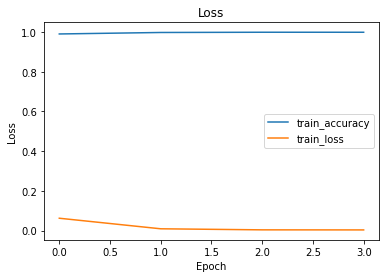

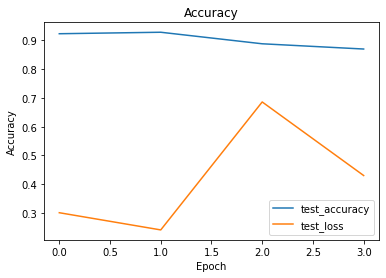

In [67]:
# plot loss
plt.plot(accuracies, label='train_accuracy')
plt.plot(losses, label='train_loss')
plt.legend()
plt.title('Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

# plot accuracy
plt.plot(test_accuracies, label='test_accuracy')
plt.plot(test_losses, label='test_loss')
plt.legend()
plt.title('Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.show()


In [68]:
cm = confusion_matrix(test_preds_list, test_class)
print(cm)

[[4799  365]
 [1126 5153]]
